In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.mesh as mesh
import tensorflow as tf
from PIL import Image
from pyeit.mesh.shape import thorax
from sciopy import norm_data, plot_mesh
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tqdm import tqdm
from support import GREIT_sample

2023-11-02 14:38:28.954875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Could not import module: serial


![gif](../codes/r_traj.gif)

In [2]:
l_path = "../data/h0=0.05_n_el=16_r_obj=0.3_dist_exc=8_step_meas=4noise=TrueT=10/"

In [3]:
tmp = np.load(l_path + "sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

In [4]:
# create empty mesh:
mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"])

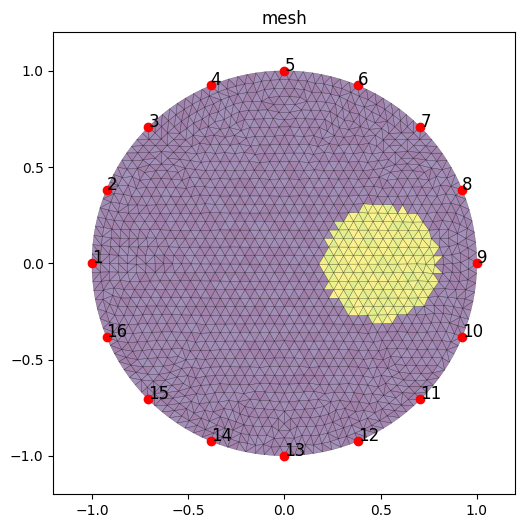

In [5]:
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [6]:
V = list()
posis_xy = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path + ele, allow_pickle=True)
    V.append(tmp_l["v_obj"])
    posis_xy.append(tmp_l["anomaly"].tolist().center)

V = np.array(V)
posis_xy = np.array(posis_xy)

100%|██████████| 10000/10000 [00:24<00:00, 409.65it/s]


In [7]:
norm = False
if norm:
    V_all = np.array([norm_data(dat) for dat in V_all])
else:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(V)
    V_all = scaler.transform(V)
    V_all = V_all**(1/2)

<StemContainer object of 3 artists>

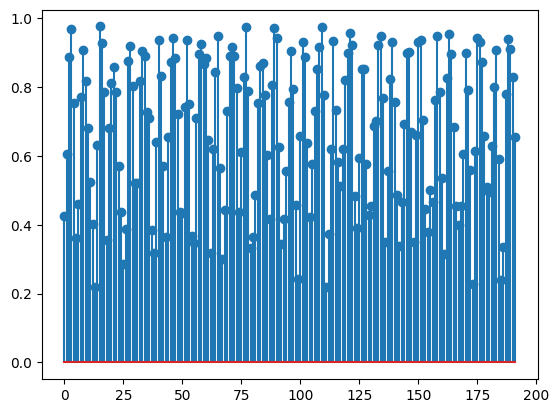

In [8]:
plt.stem(V_all[10, :])

In [9]:
nseg = 4

X = [V_all[n : n + nseg, :] for n in range(V_all.shape[0] - nseg)]
X = np.array(X)

Y = np.array(V_all[nseg:])

In [10]:
print(X.shape, Y.shape)

(9996, 4, 192) (9996, 192)


In [11]:
# X = [t0, t1, t2, t3]
# Y = [t4]
np.allclose(X[1, 3, :], Y[0, :])

True

In [12]:
X_lstm_train, X_lstm_test, Y_lstm_train, Y_lstm_test = train_test_split(
    X, Y, test_size=0.1, shuffle=False, random_state=52
)

In [13]:
np.allclose(X_lstm_test[10, 3, :], Y_lstm_test[9, :])

True

## Build LSTM

In [14]:
latent_dim = 192


def lstm_split(input_shape, nseg, v_shape):
    def Slice(s):
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = layers.Dense(v_shape, activation="relu")
    inputs = layers.Input(shape=input_shape)
    con_list = []
    for s in range(nseg):
        # slicing x
        x = layers.Lambda(Slice(s))(inputs)
        # shared layers
        x = dense(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = layers.Concatenate(axis=1)(con_list)
    x = layers.Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = layers.LSTM(v_shape)(x)
    x = layers.Activation("softmax")(x)

    return Model(inputs, x)

In [15]:
lstm = lstm_split(input_shape=(nseg, latent_dim), nseg=nseg, v_shape=V_all.shape[1])
lstm.compile(optimizer="adam", loss="binary_crossentropy")
print(lstm.summary())

2023-11-02 14:39:05.401694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-02 14:39:05.403486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 192)]     0           []                               
                                                                                                  
 lambda (Lambda)                (None, 192)          0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 192)          0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 192)          0           ['input_1[0][0]']                
                                                                                              

2023-11-02 14:39:05.986896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-02 14:39:05.988136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-02 14:39:05.989091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
epochs = 25
batch_size = 32

history = lstm.fit(
    X_lstm_train,
    Y_lstm_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_lstm_test, Y_lstm_test),
)

Epoch 1/25


2023-11-02 14:39:06.367896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-02 14:39:06.369208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-02 14:39:06.370307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  1/282 [..............................] - ETA: 14:02 - loss: 0.6985

2023-11-02 14:39:08.982998: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/282 [============================>.] - ETA: 0s - loss: 0.5751

2023-11-02 14:39:10.844876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-02 14:39:10.845964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-02 14:39:10.847332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

282/282 [==============================] - 5s 7ms/step - loss: 0.5749 - val_loss: 0.5633
Epoch 2/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5628 - val_loss: 0.5625
Epoch 3/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5624 - val_loss: 0.5623
Epoch 4/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5623 - val_loss: 0.5623
Epoch 5/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5622 - val_loss: 0.5622
Epoch 6/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5622 - val_loss: 0.5621
Epoch 7/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5622 - val_loss: 0.5621
Epoch 8/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5621 - val_loss: 0.5622
Epoch 9/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5621 - val_loss: 0.5621
Epoch 10/25
282/282 [==============================] - 2s 6ms/step - loss: 0.5621 - val_loss: 0.5620
Epoch 11/2

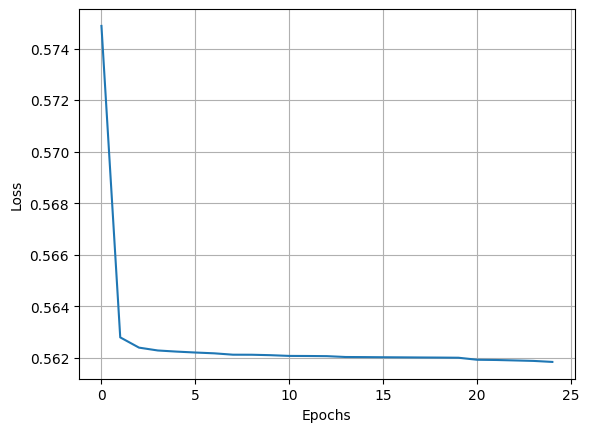

In [17]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [18]:
pred = lstm.predict(X_lstm_test)

32/32 [==============================] - 0s 2ms/step


2023-11-02 14:39:50.411589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-02 14:39:50.412737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-02 14:39:50.413850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<StemContainer object of 3 artists>

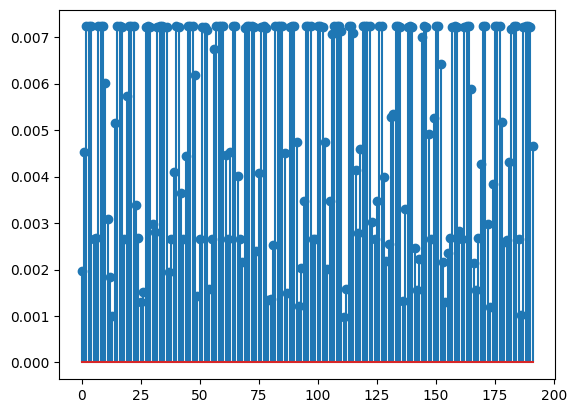

In [19]:
plt.stem(pred[10, :])

In [20]:
pred_itransf = scaler.inverse_transform(pred)

In [21]:
pred_itransf = pred_itransf**2

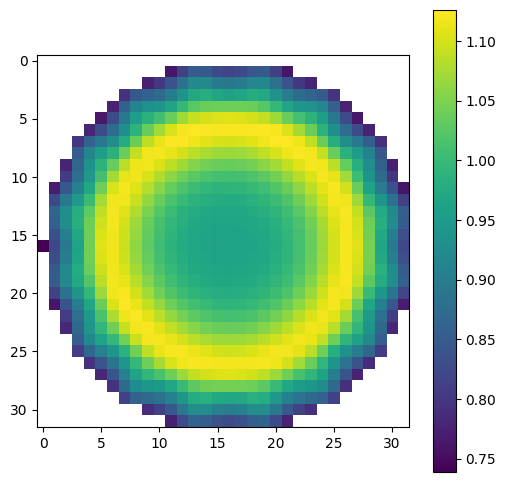

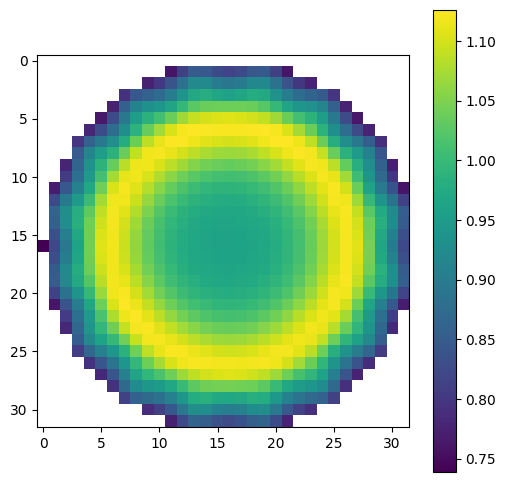

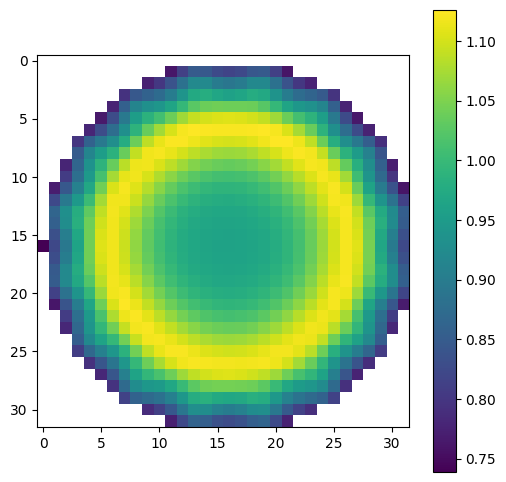

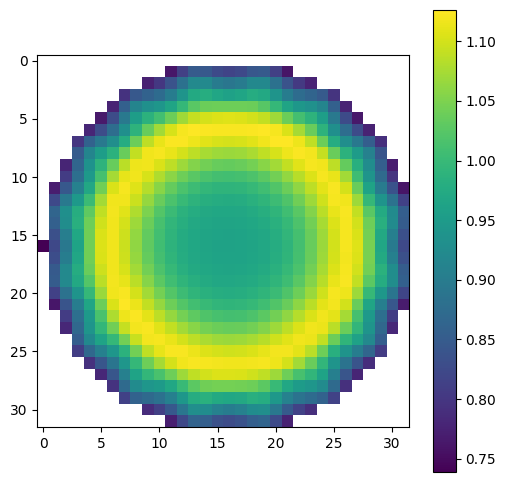

In [23]:
for l in range(1,100,25):
    rec_tmp = {
        "anomaly": tmp["anomaly"],
        "perm_array": tmp["perm_array"],
        "n_el": tmp["n_el"],
        "h0": tmp["h0"],
        "v_empty": tmp["v_empty"],
        "v_obj": pred_itransf[l, :],
        "dist_exc": tmp["dist_exc"],
        "step_meas": tmp["step_meas"],
    }
    GREIT_sample(rec_tmp, rec_only=True)